In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

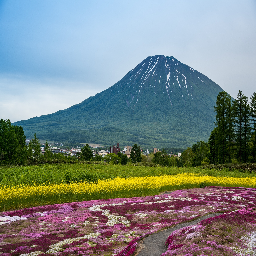

In [2]:
image_path = "/Users/akhildevarashetti/code/vision_lab/vision_lab/generation/diffusion/image.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
Image.fromarray(image)

In [3]:
# Set up parameters
T = 1000  # Number of steps
x0 = image.copy()  # Initial image

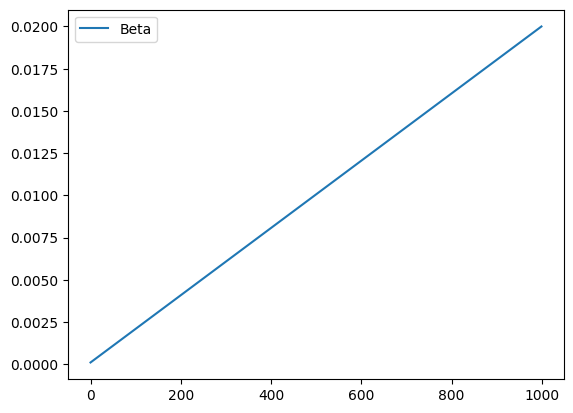

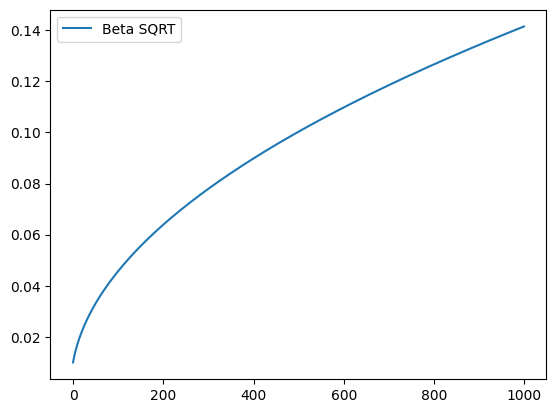

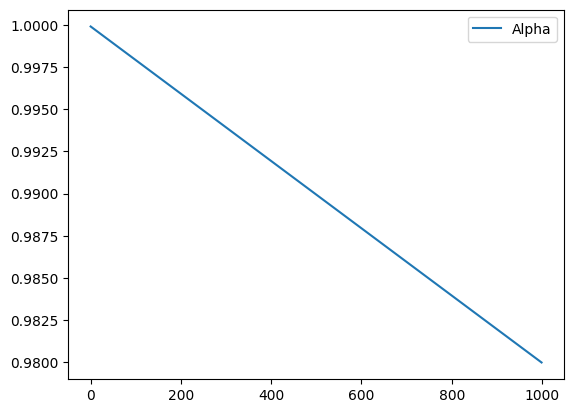

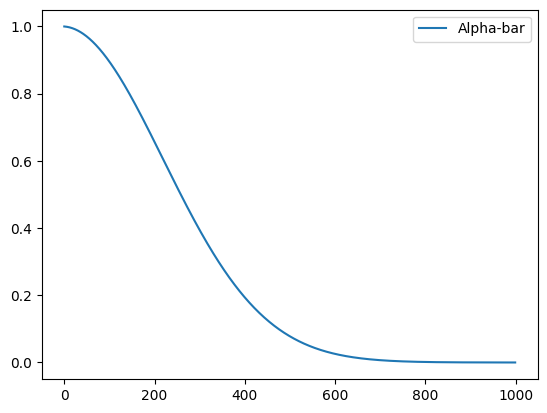

In [4]:
# Noise schedule (linear for simplicity)
beta = np.linspace(0.0001, 0.02, T)
alpha = 1 - beta
alphabar = np.cumprod(alpha)  # Cumulative product of alpha

plt.plot(beta, label="Beta")
plt.legend()
plt.show()

plt.plot(np.sqrt(beta), label="Beta SQRT")
plt.legend()
plt.show()

plt.plot(alpha, label="Alpha")
plt.legend()
plt.show()

plt.plot(alphabar, label="Alpha-bar")
plt.legend()
plt.show()

In [5]:
# Step 1: Manual step-by-step forward process
def manual_forward_process(x0, T, beta):
    noisy_images = [x0]
    x_t = x0.copy()
    for t in range(T):
        noise = np.random.randn(*x0.shape)
        x_t = np.sqrt(1 - beta[t]) * x_t + np.sqrt(beta[t]) * noise
        noisy_images.append(x_t)
    return noisy_images

# Manual process
manual_noisy_images = manual_forward_process(x0, T, beta)
len(manual_noisy_images), manual_noisy_images[0].shape

(1001, (256, 256, 3))

0


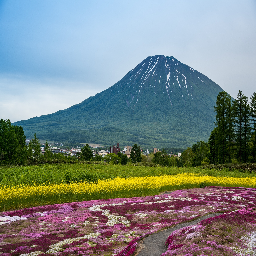

100


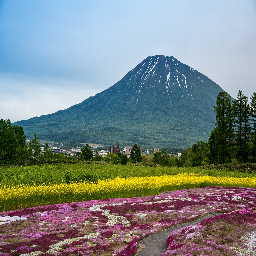

200


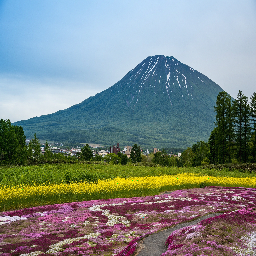

300


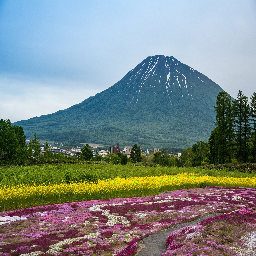

400


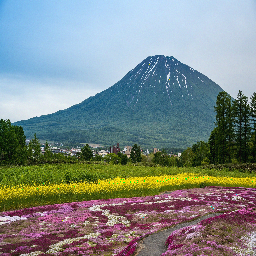

500


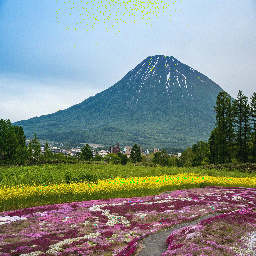

600


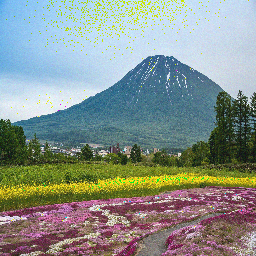

700


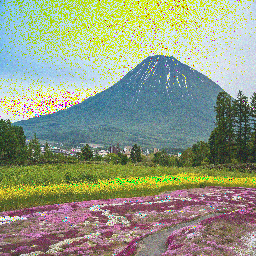

800


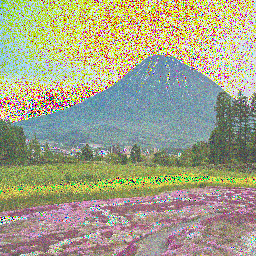

900


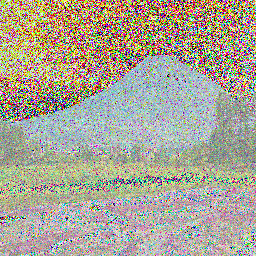

1000


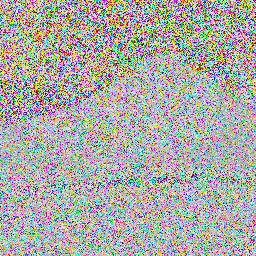

In [6]:
# Visualization
for i in range(0, T+1, 100):
    print(i)
    # display(Image.fromarray(manual_noisy_images[i].clip(0, 255).astype(np.uint8)))
    # plt.imshow(manual_noisy_images[i].clip(0, 255).astype(np.uint8))

    img = manual_noisy_images[i]
    # 0 min, 255 max
    img = (img - img.min()) / img.max()
    img = img * 255
    img = img.astype(np.uint8)
    display(Image.fromarray(img))

In [7]:
# Step 2: Single-step forward trick
def single_step_forward(x0, step, alphabar):
    noise = np.random.randn(*x0.shape)
    sqrt_alphabar_t = np.sqrt(alphabar[step])
    sqrt_one_minus_alphabar_t = np.sqrt(1 - alphabar[step])
    x_t = sqrt_alphabar_t * x0 + sqrt_one_minus_alphabar_t * noise
    return x_t, noise

In [8]:
closed_form_noisy_images = [x0]
for t in range(T):
    x_t, noise = single_step_forward(x0, t, alphabar)
    closed_form_noisy_images.append(x_t)
len(closed_form_noisy_images), closed_form_noisy_images[0].shape

(1001, (256, 256, 3))

0


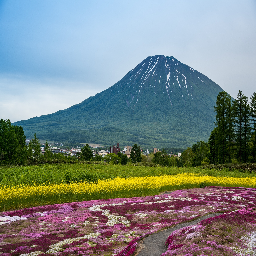

100


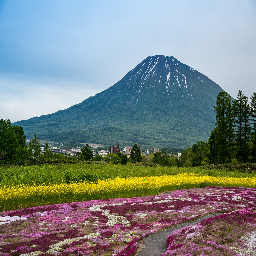

200


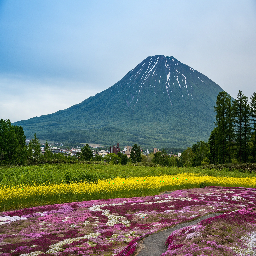

300


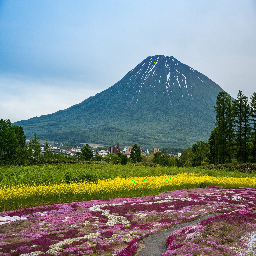

400


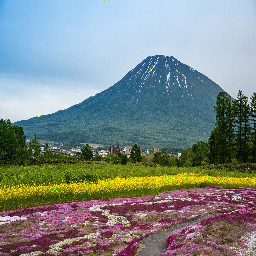

500


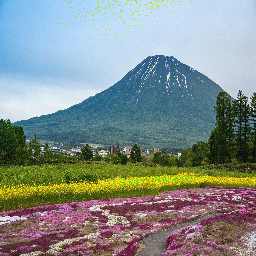

600


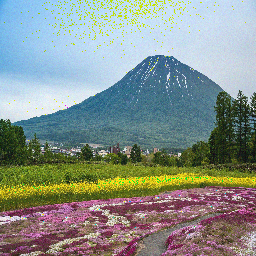

700


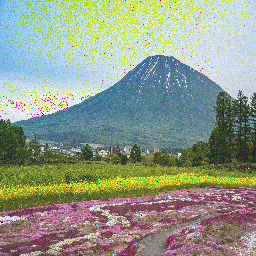

800


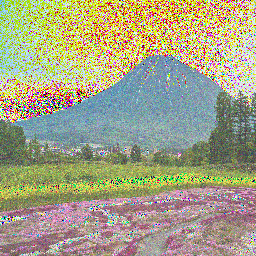

900


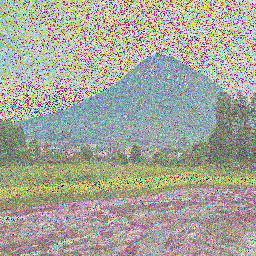

1000


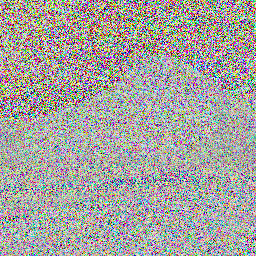

In [9]:
# Visualization
for i in range(0, T + 1, 100):
    print(i)
    # display(Image.fromarray(closed_form_noisy_images[i].clip(0, 255).astype(np.uint8)))
    # plt.imshow(closed_form_noisy_images[i].clip(0, 255).astype(np.uint8))
    # plt.imshow(closed_form_noisy_images[i], cmap="gray")
    # plt.show()
    img = closed_form_noisy_images[i]
    # 0 min, 255 max
    img = (img - img.min()) / img.max()
    img = img * 255
    img = img.astype(np.uint8)
    display(Image.fromarray(img))

In [10]:
# Step 3: Validate the difference
# Sample 100 uniformly.
sampled_indices = np.linspace(0, T, 11).astype(int)
manual_samples = [manual_noisy_images[i] for i in sampled_indices]  # (11, 256, 256, 3)
closed_form_samples = [closed_form_noisy_images[i] for i in sampled_indices]  # (11, 256, 256, 3)

manual_samples = np.array(manual_samples)
closed_form_samples = np.array(closed_form_samples)

manual_mag = manual_samples.mean(axis=(1, 2, 3))  # (11,)
closed_mag = closed_form_samples.mean(axis=(1, 2, 3))  # (11,)

# Check if the difference between manual and closed-form is negligible
# Do an outer difference to get a 11x11 matrix
diff_mag = np.subtract.outer(manual_mag, closed_mag)
diff_mag = np.abs(diff_mag)
diff_mag

array([[0.00000000e+00, 6.77305320e+00, 2.40968487e+01, 4.74232563e+01,
        7.14822252e+01, 9.21498616e+01, 1.07448259e+02, 1.17361854e+02,
        1.23034895e+02, 1.25922100e+02, 1.27229591e+02],
       [6.77285446e+00, 1.98738412e-04, 1.73239942e+01, 4.06504018e+01,
        6.47093707e+01, 8.53770071e+01, 1.00675405e+02, 1.10588999e+02,
        1.16262040e+02, 1.19149245e+02, 1.20456736e+02],
       [2.40976374e+01, 1.73245842e+01, 7.88743246e-04, 2.33256189e+01,
        4.73845878e+01, 6.80522242e+01, 8.33506220e+01, 9.32642164e+01,
        9.89372574e+01, 1.01824462e+02, 1.03131953e+02],
       [4.74259214e+01, 4.06528682e+01, 2.33290728e+01, 2.66514730e-03,
        2.40563038e+01, 4.47239401e+01, 6.00223380e+01, 6.99359324e+01,
        7.56089734e+01, 7.84961784e+01, 7.98036692e+01],
       [7.14829823e+01, 6.47099291e+01, 4.73861336e+01, 2.40597260e+01,
        7.57083639e-04, 2.06668793e+01, 3.59652771e+01, 4.58788715e+01,
        5.15519125e+01, 5.44391175e+01, 5.57466084e+

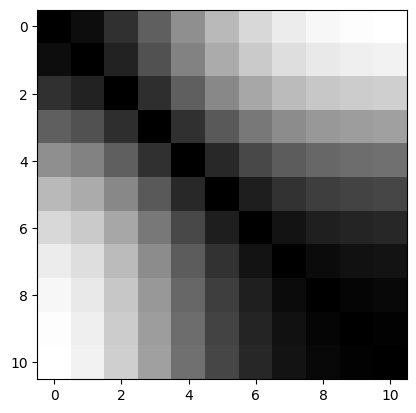

In [11]:
plt.imshow(diff_mag, cmap="gray")

In [12]:
# Single-step process
single_step_noisy_image, used_noise = single_step_forward(x0, 1, alphabar)

# Step 3: Validate the difference
final_manual_noisy_image = manual_noisy_images[1]

# Check if the difference between manual and single-step is negligible
difference = np.abs(final_manual_noisy_image - single_step_noisy_image)

print("Maximum difference between manual and single-step forward process:", np.max(difference))

Maximum difference between manual and single-step forward process: 0.10071523108408087


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037322503832580727..254.99986681698797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04702568002616489..254.98866588697263].


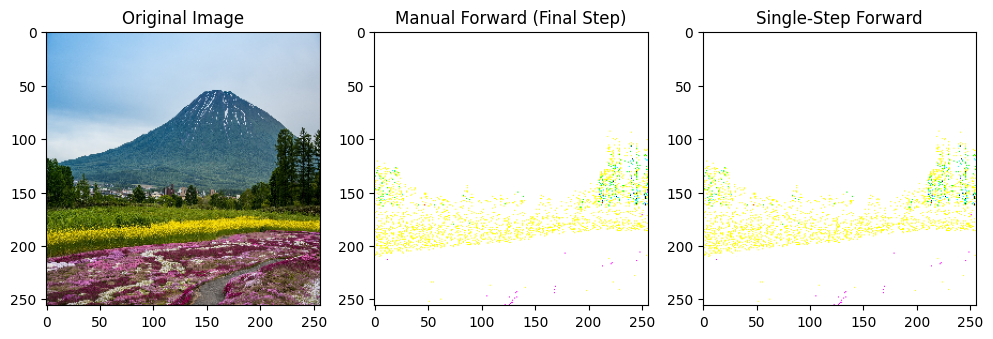

In [13]:
# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x0, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Manual Forward (Final Step)")
plt.imshow(final_manual_noisy_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Single-Step Forward")
plt.imshow(single_step_noisy_image, cmap='gray')

plt.show()
